In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import string
import re
import numpy as np
import umap.umap_ as umap
import joblib
import pickle
from sklearn.preprocessing import RobustScaler, FunctionTransformer, StandardScaler, MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA, TruncatedSVD
from matplotlib import cm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sentence_transformers import SentenceTransformer

In [ ]:
df_merged = pd.read_csv('data/processed/Ingredients_And_Nutrition_Merged_New.csv')

In [20]:
nutri_cols = ["calories", "protein", "fat", "carbohydrate"]
diet_prefs = [
    "halal", "is_lactose_free", "low_carb", "weight_loss", 
    "high_protein", "gluten_free", "dairy_free",
    "is_spicy", "is_not_fried"
]

allergen_cols = [
    "has_dairy","has_egg","has_fish","has_shellfish","has_soy","has_sesame",
    "has_wheat","has_peanut","has_treenut"
]
df_merged['text_feature'] =(
    df_merged['Title'].astype(str) + " " +
    df_merged['Ingredients_Text'].astype(str) + " "
)

In [21]:
from sklearn.preprocessing import Normalizer, MaxAbsScaler
from sklearn.decomposition import PCA

# Weighting Helper
def apply_weight(X, weight=1.0):
    return X * weight

# Pipeline
nutri_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('weight', FunctionTransformer(apply_weight, kw_args={'weight': 3.0}))
])

text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,3),
    min_df=3,
    max_df=0.8,
    stop_words='english',
    sublinear_tf=True)),
    ('svd', TruncatedSVD(n_components=50, random_state=42)),
    ('weight', FunctionTransformer(apply_weight, kw_args={'weight': 1.0}))
])

categorical_pipe_1_0 = Pipeline([
    ('scaler', MaxAbsScaler()),
    ('weight', FunctionTransformer(apply_weight, kw_args={'weight': 0.5}))
])

# 2. Preprocessor tetap sama
preprocessor = ColumnTransformer(
    transformers=[
        ('nutri',    nutri_pipe, nutri_cols),
        ('text',     text_pipe, 'text_feature'),
        ('allergen', categorical_pipe_1_0, allergen_cols),
        ('diet',     categorical_pipe_1_0, diet_prefs)
    ],
    remainder='drop'
)

# 3. Buat Final Pipeline dengan Normalizer
final_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

X_food_a = final_pipeline.fit_transform(df_merged)

In [22]:
final_pipeline

,steps,"[('preprocessor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('nutri', ...), ('text', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Training Agglomerative (Ward) for k=2...
   Silhouette Score: 0.4790
Training Agglomerative (Ward) for k=3...
   Silhouette Score: 0.4526
Training Agglomerative (Ward) for k=4...
   Silhouette Score: 0.4170
Training Agglomerative (Ward) for k=5...
   Silhouette Score: 0.4198
Training Agglomerative (Ward) for k=6...
   Silhouette Score: 0.2214
Training Agglomerative (Ward) for k=7...
   Silhouette Score: 0.2449
Training Agglomerative (Ward) for k=8...
   Silhouette Score: 0.2491
Training Agglomerative (Ward) for k=9...
   Silhouette Score: 0.2500


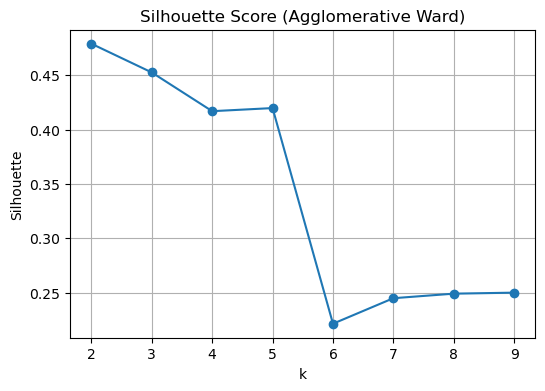

In [23]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

sil_scores = []
K_values = range(2, 10, 1)  # k = 2 sampai 9

for k in K_values:
    print(f"Training Agglomerative (Ward) for k={k}...")

    agg = AgglomerativeClustering(
        n_clusters=k,
        linkage='ward'  # WAJIB euclidean
    )
    
    labels = agg.fit_predict(X_food_a)

    # Silhouette (pakai sample_size kalau data besar)
    if len(X_food_a) > 10000:
        sil = silhouette_score(
            X_food_a,
            labels,
            sample_size=10000,
            random_state=42
        )
    else:
        sil = silhouette_score(X_food_a, labels)

    sil_scores.append(sil)
    print(f"   Silhouette Score: {sil:.4f}")

# =====================
# Plot Silhouette
# =====================
plt.figure(figsize=(6,4))
plt.plot(K_values, sil_scores, '-o')
plt.title("Silhouette Score (Agglomerative Ward)")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.grid(True)
plt.show()


--- Evaluasi Agglomerative Clustering ---
Silhouette Score: 0.41983895319910525
Davies-Bouldin Index: 1.0919741543202162
Calinski-Harabasz Index: 1835.955647020651



C:\Users\ardik\AppData\Local\Temp\ipykernel_3564\1678078724.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Agglo_Cluster', y=feature, data=df_merged, palette='tab10', showfliers=False)
C:\Users\ardik\AppData\Local\Temp\ipykernel_3564\1678078724.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Agglo_Cluster', y=feature, data=df_merged, palette='tab10', showfliers=False)
C:\Users\ardik\AppData\Local\Temp\ipykernel_3564\1678078724.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Agglo_Cluster', y=feature, data=df_merged, 

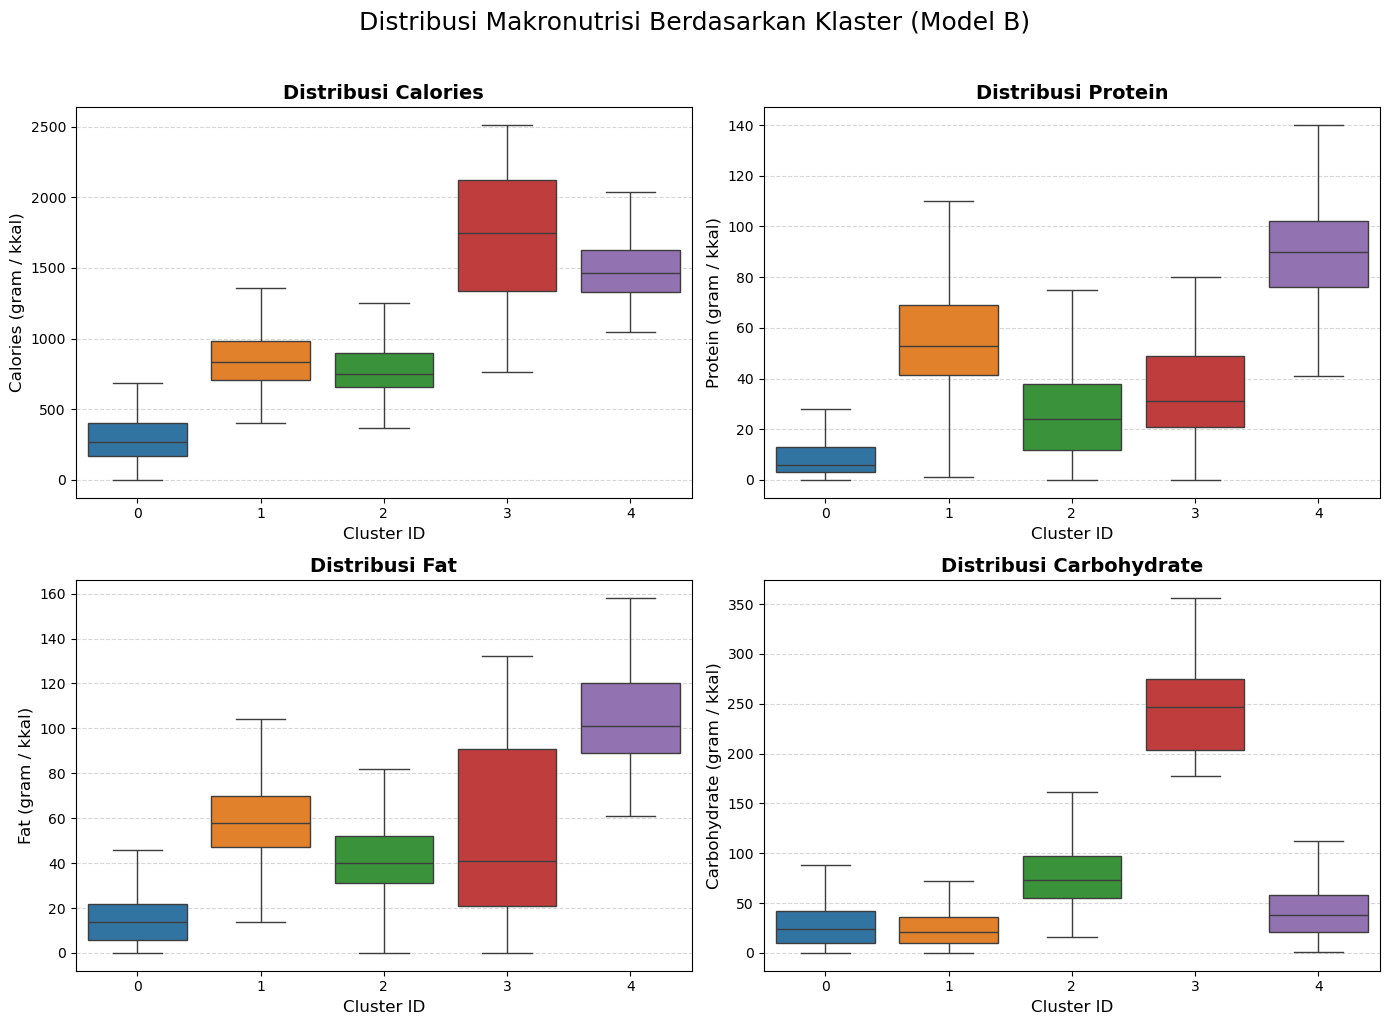

In [24]:
from sklearn.cluster import AgglomerativeClustering

def evaluate_clustering(X, labels, model_name):
    """ Evaluate clustering performance using Silhouette, Davies-Bouldin, and Calinski-Harabasz scores."""
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    
    print(f"--- Evaluasi {model_name} ---")
    print(f"Silhouette Score: {sil}")
    print(f"Davies-Bouldin Index: {db}")
    print(f"Calinski-Harabasz Index: {ch}\n")
    return sil, db, ch


# 1. Jalankan Agglomerative
k = 5
agglo = AgglomerativeClustering(n_clusters=k, linkage='ward') 
agglo_labels = agglo.fit_predict(X_food_a)

# 2. Evaluasi menggunakan fungsi yang kita buat tadi
agglo_metrics = evaluate_clustering(X_food_a, agglo_labels, "Agglomerative Clustering")

# 3. Visualisasi
plt.figure(figsize=(14, 10))
plt.suptitle("Distribusi Makronutrisi Berdasarkan Klaster (Model B)", fontsize=18, y=1.02)

df_merged['Agglo_Cluster'] = agglo_labels

for i, feature in enumerate(nutri_cols, 1):
    plt.subplot(2, 2, i)
    
    sns.boxplot(x='Agglo_Cluster', y=feature, data=df_merged, palette='tab10', showfliers=False)
    
    plt.title(f'Distribusi {feature.capitalize()}', fontsize=14, fontweight='bold')
    plt.xlabel('Cluster ID', fontsize=12)
    plt.ylabel(f'{feature.capitalize()} (gram / kkal)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [25]:
# 4. Print Persebaran Data
cluster_counts = pd.Series(agglo_labels).value_counts().sort_index()
total_data = len(agglo_labels)

print("\n" + "="*30)
print("PERSEBARAN DATA CLUSTER")
print("="*30)
for cluster_id, count in cluster_counts.items():
    percentage = (count / total_data) * 100
    print(f"Cluster {cluster_id}: {count} resep ({percentage:.2f}%)")
print("="*30)
print(f"Total: {total_data} resep")


PERSEBARAN DATA CLUSTER
Cluster 0: 3055 resep (73.23%)
Cluster 1: 423 resep (10.14%)
Cluster 2: 532 resep (12.75%)
Cluster 3: 37 resep (0.89%)
Cluster 4: 125 resep (3.00%)
Total: 4172 resep


In [26]:
df_merged['Agglo_Cluster'] = agglo_labels

In [27]:
for c in range(k):
    print(f"\n===== Cluster {c} =====")
    print(df_merged[df_merged.Agglo_Cluster == c]["Title"].head(30).tolist())



===== Cluster 0 =====
['Italian Sausage and Bread Stuffing', 'Butternut Squash and Apple Soup', 'Shrimp Creole', 'Coconut Rice', 'Dashi', 'Peach Cobbler', 'White Russian', 'Aviation', 'Manhattan', 'Negroni', 'Lavash', 'Banana Cream Pie', 'Sazerac', 'Cheddar Potato Soup with Bacon', 'Zucchini Noodles with Anchovy Butter', 'Cold Soba Noodles with Miso and Smoked Tofu', 'Chicken Piccata', 'Muhammara', 'One-of-Each Soup', 'Crispy Fried Shallots', "Liu Shaokun's Spicy Buckwheat Noodles with Chicken", 'Candied Kumquats', 'Butternut Squash and Creamed-Spinach Gratin', 'Roasted Brussels Sprouts with Garlic and Pancetta', 'Parmesan-Roasted Butternut Squash', 'Chopped Salad', 'Antipasto Salad', 'Lemony Yogurt Sauce', 'Ayran', 'Garlic Broth']

===== Cluster 1 =====
["My Mother's Brisket", 'Grilled Marinated Leg of Lamb', 'Potato, Leek, and Pea Pot Pie with Spinach-Arugula Salad', 'Chicken and Artichoke Fricassée with Morel Mushrooms', 'Leg of Lamb with Garlic and Rosemary', 'Lobster Fra Diavolo'

In [28]:
pd.set_option('display.max_columns', None)

In [29]:
# 1. Tentukan kolom yang ingin di-profile
profile_cols = ["calories", "protein", "fat", "carbohydrate", "cooking_time"]

# 2. Buat tabel profiling dengan agregasi Lengkap
cluster_profiling = df_merged.groupby('Agglo_Cluster')[profile_cols].agg(['mean', 'min', 'max', 'std']).round(2)

# 3. Tambahkan jumlah data per cluster agar terlihat bobotnya
cluster_profiling['count'] = df_merged['Agglo_Cluster'].value_counts().sort_index()

# Menampilkan tabelt
print("=== Tabel Profiling Cluster Nutrisi ===")
display(cluster_profiling)

=== Tabel Profiling Cluster Nutrisi ===


calories                         protein                      \
                  mean     min     max     std    mean   min    max    std   
Agglo_Cluster                                                                
0               287.71     0.0   686.0  150.24   10.04   0.0   61.0  11.17   
1               858.14   406.0  1497.0  201.59   55.36   0.0  150.0  24.29   
2               800.48   369.0  1648.0  207.49   26.82   0.0   81.0  16.98   
3              1696.68   765.0  2511.0  489.93   39.11   0.0  107.0  30.39   
4              1492.44  1046.0  2341.0  219.66   89.02  25.0  156.0  22.87   

                  fat                     carbohydrate                         \
                 mean   min    max    std         mean     min     max    std   
Agglo_Cluster                                                                   
0               15.08   0.0   48.0  11.15        27.95    0.00   96.75  20.59   
1               59.56   8.0  140.0  22.64        25.16    0.00  115.00  18.57   
2               42.12   0.0  103.0  18.44        78.54   16.00  189.25  31.81   
3               52.24   0.0  132.0  39.49       267.51  177.75  569.75  86.12   
4              106.54  61.0  158.0  23.31        44.36    0.75  142.75  31.86   

              cooking_time                   count  
                      mean min   max     std        
Agglo_Cluster                                       
0                    88.54   1  4320  199.97  3055  
1                   167.53   1  2880  348.98   423  
2                   101.84   1  1440  177.19   532  
3                   148.22   1  2160  359.28    37  
4                   224.62   2  2880  378.77   125

In [ ]:
df_model_a = df_merged[['recipe_id', 'Title', 'text_feature', 'cooking_time'] + nutri_cols + allergen_cols + diet_prefs ].copy()
df_model_a['cluster'] = agglo_labels

# Menyiapkan dictionary untuk di-save
model_a_data = {
    'metadata': df_model_a,      
    'matrix_a': X_food_a.astype('float32'),        
    'pipeline_a': final_pipeline 
}

# Simpan ke file pickle
with open('models/nutri_engine_agglo.pkl', 'wb') as f:
    pickle.dump(model_a_data, f)

print("Success !!")


Success !!
